# Points

Data Source - https://msi.nga.mil/Publications/WPI

- Convert the excel file into a csv and save to the resources folder.
- Alternatively, there is a ports.csv file in the resources folder with a series of lat/longs placed randomly at the coast.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
ports = pd.read_csv("/content/drive/MyDrive/notebooks/resources/ports.csv")

In [3]:
print(ports)

             lat         lon
0      19.432680   93.554935
1      54.532050   18.526400
2      40.656520   27.663445
3      50.474590    4.009098
4      28.391250  129.503900
...          ...         ...
19838  37.062715  -79.560240
19839  34.690600  -76.560000
19840  60.094400   24.752800
19841  59.460300   16.318600
19842  29.375600   34.793900

[19843 rows x 2 columns]


In [4]:
from shapely.geometry import Point
import geopandas as gpd

port_geometry = [Point(xy) for xy in zip(ports['lon'], ports['lat'])]
port_geodata = gpd.GeoDataFrame(ports, crs="EPSG:4326", geometry=port_geometry)

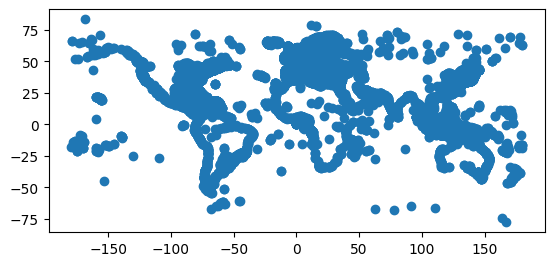

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
port_geodata.plot(ax=ax)
plt.show()

In [6]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.6 MB/s eta 0:00:00


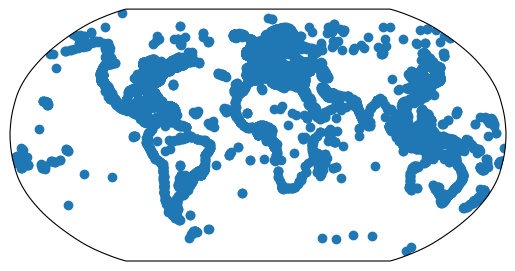

In [7]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()})
port_geodata.plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

#### Exercise


My attempt

![alt text](../resources/assets/ports.png "Title")


## Plotting Lines

Data Source - https://openflights.org/data.html

- Download airports.dat and place in the resources folder
- Download routes.dat and place in the resources folder

In [8]:
airports = pd.read_csv("/content/drive/MyDrive/notebooks/resources/airports", delimiter=',', names=['id', 'name', 'city', 'country', 'iata',
                                                                   'icao', 'lat', 'long', 'altitude', 'timezone',
                                                                   'dst', 'tz', 'type', 'source'])

In [9]:
print(airports)

         id                                         name          city  \
0         1                               Goroka Airport        Goroka   
1         2                               Madang Airport        Madang   
2         3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3         4                               Nadzab Airport        Nadzab   
4         5  Port Moresby Jacksons International Airport  Port Moresby   
...     ...                                          ...           ...   
7693  14106                          Rogachyovo Air Base        Belaya   
7694  14107                        Ulan-Ude East Airport      Ulan Ude   
7695  14108                         Krechevitsy Air Base      Novgorod   
7696  14109                  Desierto de Atacama Airport       Copiapo   
7697  14110                           Melitopol Air Base     Melitopol   

               country iata  icao        lat        long  altitude timezone  \
0     Papua New Guinea  GKA  AYG

### Exercise

- Create a list of points from the lat/long values in the airports DataFrame
- Convert the airports dataframe to a GeoDataFrame using the list of points created above
- Generate a map of the worlds airports

In [10]:
routes = pd.read_csv("/content/drive/MyDrive/notebooks/resources/routes", delimiter=',', names=['airline', 'id', 'source_airport', 'source_airport_id',
                                                               'destination_airport', 'destination_airport_id', 'codeshare',
                                                               'stops', 'equitment'])

In [11]:
print(routes)

      airline     id source_airport source_airport_id destination_airport  \
0          2B    410            AER              2965                 KZN   
1          2B    410            ASF              2966                 KZN   
2          2B    410            ASF              2966                 MRV   
3          2B    410            CEK              2968                 KZN   
4          2B    410            CEK              2968                 OVB   
...       ...    ...            ...               ...                 ...   
67658      ZL   4178            WYA              6334                 ADL   
67659      ZM  19016            DME              4029                 FRU   
67660      ZM  19016            FRU              2912                 DME   
67661      ZM  19016            FRU              2912                 OSS   
67662      ZM  19016            OSS              2913                 FRU   

      destination_airport_id codeshare  stops equitment  
0                

In [12]:
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [13]:
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, source_airports, left_on='source_airport', right_on='iata_source')
routes = pd.merge(routes, destination_airports, left_on='destination_airport', right_on='iata_destination')

print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


In [14]:
from shapely.geometry import LineString

routes_geometry = [LineString([[routes.iloc[i]['long_source'], routes.iloc[i]['lat_source']], [routes.iloc[i]['long_destination'], routes.iloc[i]['lat_destination']]]) for i in range(routes.shape[0])]
routes_geodata = gpd.GeoDataFrame(routes, geometry=routes_geometry, crs='EPSG:4326')

In [15]:
print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


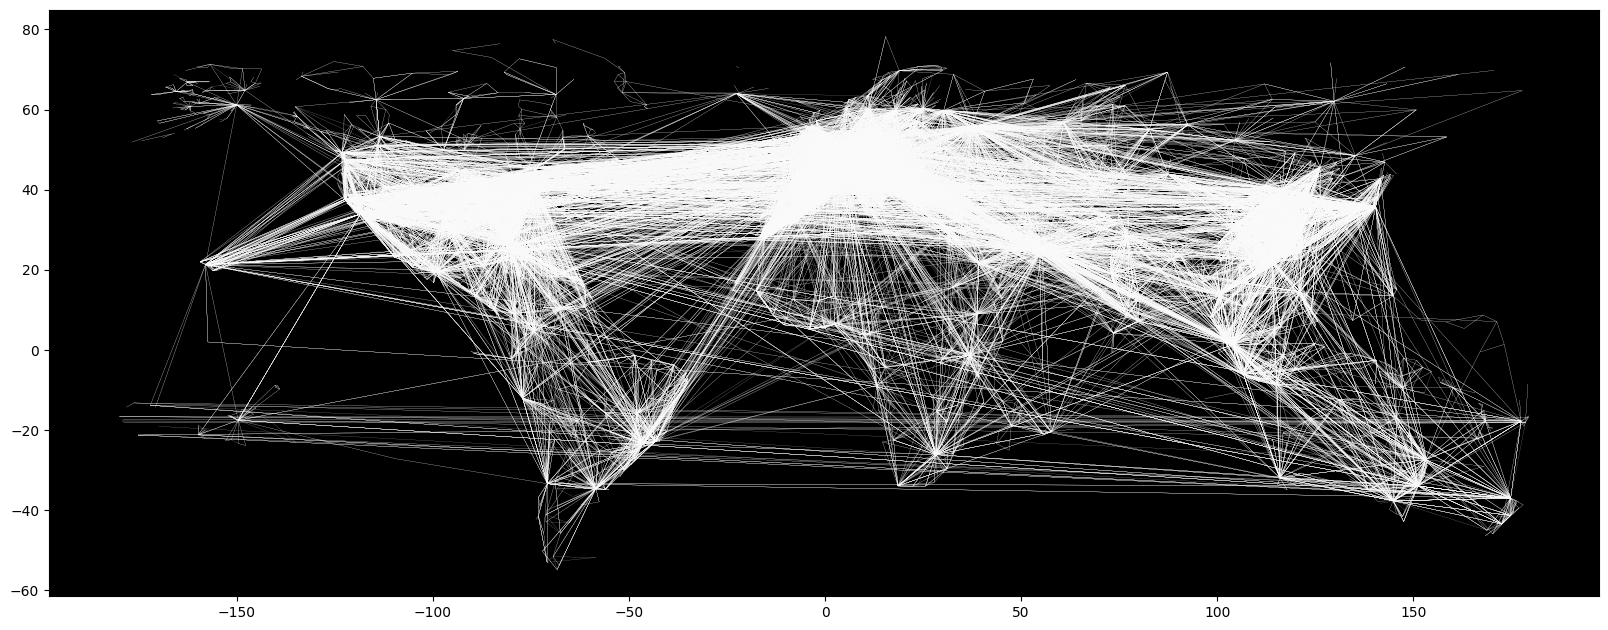

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
ax.patch.set_facecolor('black')

routes_geodata.plot(ax=ax, color='white', linewidth=0.1)

plt.show()

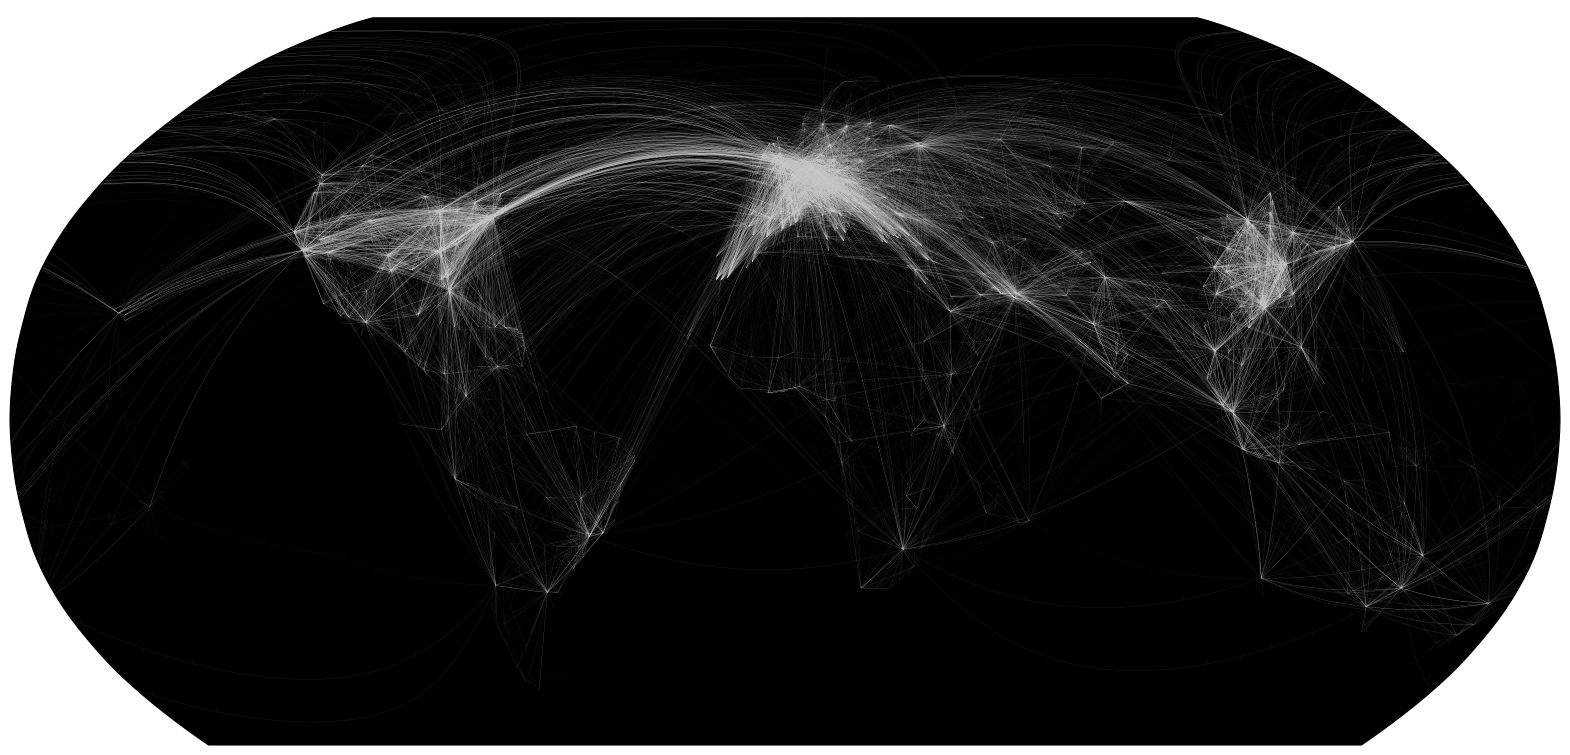

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(20,20))
ax.patch.set_facecolor('black')
routes_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)
plt.show()

In [18]:
!pip install nbconvert

In [20]:
!jupyter nbconvert --to html /content/drive/MyDrive/notebooks/Flight_Route.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/notebooks/Flight_Route.ipynb to html
[NbConvertApp] Writing 2777463 bytes to /content/drive/MyDrive/notebooks/Flight_Route.html
